#Tunagem de Hiperparâmetros

Os modelos de machine learning possuem parâmetros que podem assumir diversos valores e são capazes de alterar seu desempenho. A tunagem de hiperparâmetros é o processo pelo qual procuramos encontrar a melhor combinação de valores para calibrar o modelo e solucionar nosso problema. Combinando-se a tunagem com um bom pré-processamento, produzimos modelos com maior poder preditivo. A tunagem, porém, é considerado como um ajuste fino, sendo o maior ganho para o modelo aquele promovido por sua alimentação com dados de qualidade

Para este projeto, continuaremos a utilizar os dados do Titanic. Faremos um novo pré-processamente, diferente do que vimos em "Flai 6 - Pré-Processamento" e utilizaremos uma função para retornar os melhores parâmetros para KNN, Árvore de Decisão e Random Forest, buscando otimizar a métrica da acurácia

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
url1 = 'https://raw.githubusercontent.com/roberta-helena/projetos_estudo/main/datasets/titanic_train.csv'
url2 = 'https://raw.githubusercontent.com/roberta-helena/projetos_estudo/main/datasets/titanic_test.csv'

treino = pd.read_csv(url1)
teste = pd.read_csv(url2)

A variável **n** recebe o tamanho do conjunto de dados de treino

In [3]:
n = treino.shape[0]

A variável **targets** recebe a variável resposta do conjunto de dados de treino

In [4]:
targets = list(treino['Survived'])

Para facilitar as alterações do pré-processamento, unimos os conjuntos de teste e de treino em um só dataset. Em etapa posterior, os separaremos novamente

In [5]:
dataset = pd.concat([treino, teste])

In [6]:
dataset.shape

(1309, 12)

##Pré-Processamento das Variáveis

Para este projeto, propomos um novo pré-processamento das variáveis

###Variável "Sexo"

Transformamos a variável **Sex** em binária, atribuindo o valor 1 para sexo feminino e 0 para sexo masculino

In [7]:
dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0})

In [8]:
dataset['Sex'].value_counts()

0    843
1    466
Name: Sex, dtype: int64

###Variável "Titulação"

Para criarmos a variável **Titulação**, retiramos os títulos dos nomes dos passageiros e os agrupamos em categorias

In [9]:
def aux(x):
  return x.split(', ')[1].split('. ')[0]

dataset['Titulo'] = dataset['Name']. apply(aux)

In [10]:
titulos = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

dataset['Titulacao'] = dataset['Titulo'].map(titulos)

In [11]:
dataset['Titulacao'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      5
Name: Titulacao, dtype: int64

Podemos verificar que tipo de informação a variável criada fornece em relação à variável que desejamos prever

In [12]:
dataset['Survived'].groupby(dataset['Titulacao']).describe()

,count,mean,std,min,25%,50%,75%,max
Titulacao,,,,,,,,
Master,40.0,0.575000,0.500641,0.0,0.0,1.0,1.00,1.0
Miss,184.0,0.701087,0.459031,0.0,0.0,1.0,1.00,1.0
Mr,517.0,0.156673,0.363844,0.0,0.0,0.0,0.00,1.0
Mrs,127.0,0.795276,0.405098,0.0,1.0,1.0,1.00,1.0
Officer,18.0,0.277778,0.460889,0.0,0.0,0.0,0.75,1.0
Royalty,5.0,0.600000,0.547723,0.0,0.0,1.0,1.00,1.0


###Variável "Cabin"

Para a variável **Cabin**, pegamos apenas sua primeira letra. Pela quantidade de valores faltantes presentes na variável, nota-se que a maior parte dos valores é representado por n (de NaN ou Not a Number)

In [13]:
def aux(x):
  return list(str(x))[0]

dataset['Cabin'] = dataset['Cabin'].apply(aux)

In [14]:
dataset['Cabin'].value_counts()

n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

###Variável "Tipos de Família"

Para indicarmos os tipos de família presentes no Titanic, contabilizamos para cada passageiro quantos passageiros estavam com ele (incluindo ele mesmo). Grupos com quatro ou menos passageiros formam famílias pequenas, grupos com mais de quatro passageiros formam famílias grandes e apenas um passageiro indica que ele estava sozinho no navio

In [15]:
dataset['Familia'] = dataset['SibSp'] + dataset['Parch'] + 1

In [16]:
def aux(x):
  if x == 1:
    return 'Sozinho'
  elif x <= 4:
    return 'Pequena'
  else:
    return 'Grande'

dataset['FamiliaTipo'] = dataset['Familia'].apply(aux)

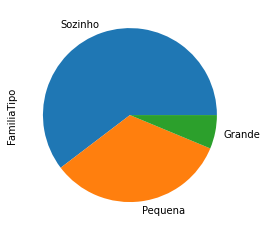

In [17]:
dataset['FamiliaTipo'].value_counts().plot(kind = 'pie')

Podemos verificar que tipo de informação a variável criada fornece em relação à variável que desejamos prever

In [18]:
dataset['Survived'].groupby(dataset['FamiliaTipo']).mean()

FamiliaTipo
Grande     0.161290
Pequena    0.578767
Sozinho    0.303538
Name: Survived, dtype: float64

###Descartando Variáveis

Descartamos as variáveis que não serão mais utilizadas

In [19]:
variaveis = ['PassengerId', 'Name', 'Ticket', 'Titulo']
dataset.drop(variaveis, axis = 1, inplace = True)

In [20]:
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Titulacao,Familia,FamiliaTipo
0,0.0,3,0,22.0,1,0,7.2500,n,S,Mr,2,Pequena
1,1.0,1,1,38.0,1,0,71.2833,C,C,Mrs,2,Pequena
2,1.0,3,1,26.0,0,0,7.9250,n,S,Miss,1,Sozinho
3,1.0,1,1,35.0,1,0,53.1000,C,S,Mrs,2,Pequena
4,0.0,3,0,35.0,0,0,8.0500,n,S,Mr,1,Sozinho


###Dummificando Variáveis

Fazemos a dummificação das variáveis com mais de duas categorias para que elas sejam apresentadas ao modelo de forma numérica

In [21]:
dummificar = ['Pclass', 'Cabin', 'Embarked', 'Titulacao', 'FamiliaTipo']
dataset = pd.get_dummies(dataset, columns = dummificar)

In [22]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Familia,Pclass_1,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_n,Embarked_C,Embarked_Q,Embarked_S,Titulacao_Master,Titulacao_Miss,Titulacao_Mr,Titulacao_Mrs,Titulacao_Officer,Titulacao_Royalty,FamiliaTipo_Grande,FamiliaTipo_Pequena,FamiliaTipo_Sozinho
0,0.0,0,22.0,1,0,7.2500,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1.0,1,38.0,1,0,71.2833,2,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,1.0,1,26.0,0,0,7.9250,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,53.1000,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0.0,0,35.0,0,0,8.0500,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1


###Valores Faltantes

VERIFICANDO DADOS FALTANTES

In [23]:
dataset.isnull().sum()

Survived               418
Sex                      0
Age                    263
SibSp                    0
Parch                    0
Fare                     1
Familia                  0
Pclass_1                 0
Pclass_2                 0
Pclass_3                 0
Cabin_A                  0
Cabin_B                  0
Cabin_C                  0
Cabin_D                  0
Cabin_E                  0
Cabin_F                  0
Cabin_G                  0
Cabin_T                  0
Cabin_n                  0
Embarked_C               0
Embarked_Q               0
Embarked_S               0
Titulacao_Master         0
Titulacao_Miss           0
Titulacao_Mr             0
Titulacao_Mrs            0
Titulacao_Officer        0
Titulacao_Royalty        0
FamiliaTipo_Grande       0
FamiliaTipo_Pequena      0
FamiliaTipo_Sozinho      0
dtype: int64

PREENCHENDO DADOS FALTANTES

Neste projeto, faremos a imputação dos dados faltantes por meio de modelagem KNN. Ajustamos a transformação nos dados de treinamento e utilizamos o mesmo ajuste também nos dados de teste

In [24]:
imputer = KNNImputer()

knnimp = imputer.fit(dataset.loc[:n-1, :].drop('Survived', axis = 1))
knnimp = imputer.transform(dataset.drop('Survived', axis = 1))

In [25]:
dataset = pd.DataFrame(knnimp, columns = dataset.columns[1:])

In [26]:
dataset.isnull().sum()

Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Familia                0
Pclass_1               0
Pclass_2               0
Pclass_3               0
Cabin_A                0
Cabin_B                0
Cabin_C                0
Cabin_D                0
Cabin_E                0
Cabin_F                0
Cabin_G                0
Cabin_T                0
Cabin_n                0
Embarked_C             0
Embarked_Q             0
Embarked_S             0
Titulacao_Master       0
Titulacao_Miss         0
Titulacao_Mr           0
Titulacao_Mrs          0
Titulacao_Officer      0
Titulacao_Royalty      0
FamiliaTipo_Grande     0
FamiliaTipo_Pequena    0
FamiliaTipo_Sozinho    0
dtype: int64

###Padronização das Variáveis

Antes de alterarmos a escala das variáveis por padronização, redividimos o conjunto de dados no conjunto treino e no conjunto teste

In [27]:
treino = dataset.loc[:n-1, :]
teste = dataset.loc[n:, :]

Utilizando a função Standard Scaler, ajustamos a transformação nos dados de treinamento e utilizamos o mesmo ajuste também nos dados de teste

In [28]:
sc = StandardScaler()

aux0 = sc.fit_transform(treino[['Age', 'Fare']])
aux1 = pd.DataFrame(aux0, columns = ['Idade', 'Tarifa'])
treino = pd.concat([treino, aux1], axis = 1)
treino.drop(['Age', 'Fare'], axis = 1, inplace = True)

In [29]:
treino.head()

,Sex,SibSp,Parch,Familia,Pclass_1,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_n,Embarked_C,Embarked_Q,Embarked_S,Titulacao_Master,Titulacao_Miss,Titulacao_Mr,Titulacao_Mrs,Titulacao_Officer,Titulacao_Royalty,FamiliaTipo_Grande,FamiliaTipo_Pequena,FamiliaTipo_Sozinho,Idade,Tarifa
0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.575796,-0.502445
1,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.598609,0.786845
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.282195,-0.488854
3,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.378408,0.420730
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.378408,-0.486337


In [30]:
aux0 = sc.transform(teste[['Age', 'Fare']])
aux1 = pd.DataFrame(aux0, columns = ['Idade', 'Tarifa'])
teste = teste.reset_index()
teste = pd.concat([teste, aux1], axis = 1)
teste.drop(['Age', 'Fare', 'index'], axis = 1, inplace = True)

In [31]:
teste.head()

,Sex,SibSp,Parch,Familia,Pclass_1,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_n,Embarked_C,Embarked_Q,Embarked_S,Titulacao_Master,Titulacao_Miss,Titulacao_Mr,Titulacao_Mrs,Titulacao_Officer,Titulacao_Royalty,FamiliaTipo_Grande,FamiliaTipo_Pequena,FamiliaTipo_Sozinho,Idade,Tarifa
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.341708,-0.490783
1,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.259212,-0.507479
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.360217,-0.453367
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.208795,-0.474005
4,1.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.575796,-0.401017


##Escolhendo as Variáveis Mais Importantes

Feito o pré-processamento dos dados, podemos agora escolher quais variáveis serão introduzidas ao modelo

###Escolhendo com Random Forest

A escolha das variáveis mais importantes é baseada em um output de modelos de árvore chamado feature importance, que retorna a importância de cada variável para o modelo

In [32]:
modelo_base = RandomForestClassifier(max_depth = 3)
modelo_base.fit(treino, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
variaveis = pd.DataFrame()
variaveis['variavel'] = treino.columns
variaveis['importancia'] = modelo_base.feature_importances_
variaveis.sort_values(by = 'importancia', ascending = False)

,variavel,importancia
21,Titulacao_Mr,0.192829
0,Sex,0.175071
22,Titulacao_Mrs,0.130142
20,Titulacao_Miss,0.096423
29,Tarifa,0.075936
15,Cabin_n,0.062970
4,Pclass_1,0.049007
6,Pclass_3,0.041122
3,Familia,0.028452
28,Idade,0.028156


Por meio de um gráfico, podemos perceber quais são as variáveis consideradas mais importantes pela Random Forest

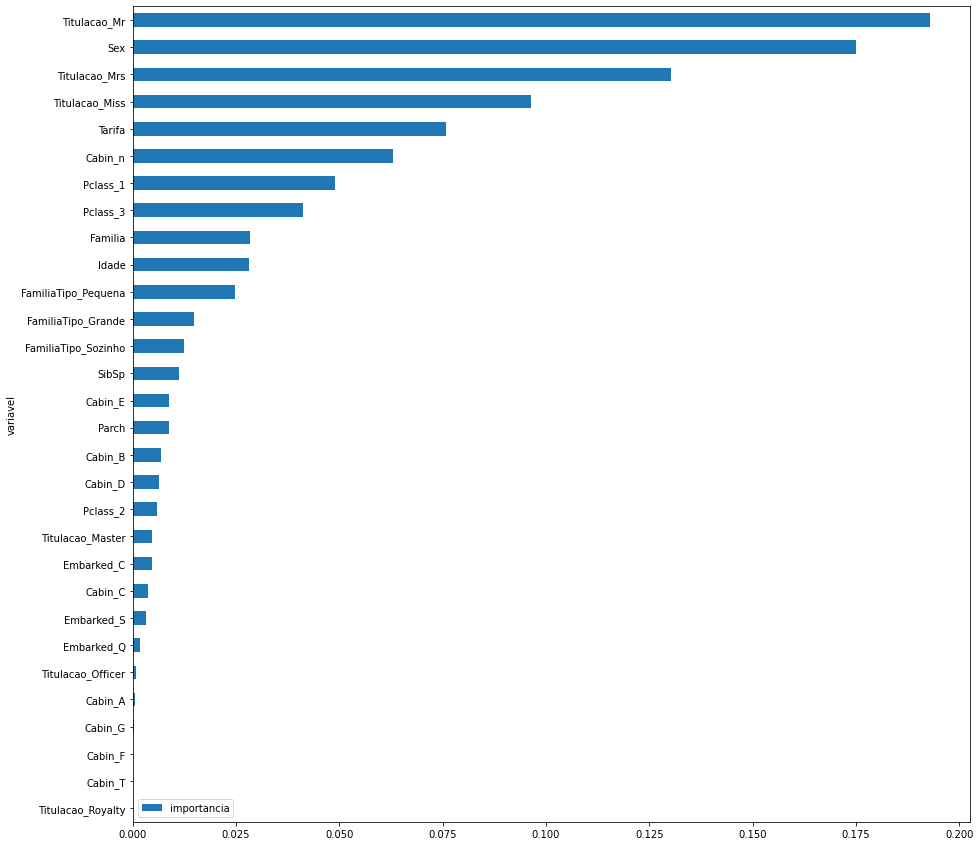

In [34]:
variaveis.sort_values(by = 'importancia', ascending = True, inplace = True)
variaveis.set_index('variavel', inplace = True)
variaveis.plot(kind='barh', figsize=(15, 15));

###Selecionando com SelectFromModel

Uma vez compreendida a importância de cada variável para o modelo, selecionamos as que são mais importantes 

In [35]:
seletor = SelectFromModel(modelo_base, prefit = True, max_features = 11, threshold = -np.inf)

treino_reduzido = seletor.transform(treino)
print(treino_reduzido.shape)

teste_reduzido = seletor.transform(teste)
print(teste_reduzido.shape)

(891, 11)
(418, 11)


##Tunagem dos Modelos

Para tunar nossos modelos, utilizaremos uma função que testa diversas combinações de parâmetros (estabelecidos na variável **parametros**). Esse teste pode ser do tipo 'tudo', que testa todas as combinações possíveis ou do tipo 'aleatório', que testa apenas uma amostra aleatória dos parâmetros. Em seguida, a função utiliza o método do K-FOLD repetido estratificado para avaliar o desempenho do modelo e retorna a combinação de parâmetros que teve o melhor desempenho em relação às demais na otimização da métrica acurácia

###Melhor KNN

In [36]:
def GridSearchKNN(treino, targets, tipo = 'tudo'):
    parametros = {'n_neighbors' : np.arange(1, 50, 2)}

    modelo = KNeighborsClassifier()
        
    validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)

    if tipo == 'tudo':
        search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = 'accuracy', cv = validacao, 
                                  verbose = 1, n_jobs = -1)
    elif tipo == 'aleatorio':
        search = RandomizedSearchCV(modelo, param_distributions = parametros,
                                scoring = 'accuracy', cv = validacao,
                                n_iter = 10, verbose = 1, n_jobs = -1)
    else:
        print('entrada invalida no argumento "tipo"')


    search.fit(treino, targets) 

    melhor = search.best_estimator_
    #best_estimator_ : melhor KNN

    print('\nAcuracia: {:.4f}'.format(search.best_score_))
    print('Melhores parâmetros: {}\n'.format(search.best_params_))
    #best_params_ : melhores parâmetros para conseguir o menlhor estimador

    return melhor

knn = GridSearchKNN(treino_reduzido, targets, tipo = 'tudo')

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Acuracia: 0.8193
Melhores parâmetros: {'n_neighbors': 19}



[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    2.7s finished


###Melhor Árvore de Decisão

In [37]:
def GridSearchARVORE(treino, targets, tipo = 'tudo'):
    parametros = {   
                 'max_depth' : np.arange(1,11), 
                 'min_samples_split': np.arange(2,12),
                 'min_samples_leaf': np.arange(1,11),
                 }

    modelo = DecisionTreeClassifier()
        
    validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)

    if tipo == 'tudo':
        grid_search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = 'accuracy', cv = validacao, 
                                  verbose = 1, n_jobs = -1)
    elif tipo == 'aleatorio':
        grid_search = RandomizedSearchCV(modelo, param_distributions = parametros,
                                scoring = 'accuracy', cv = validacao,
                                n_iter = 10, verbose = 1, n_jobs = -1)
    else:
        print('entrada invalida no argumento "tipo"')


    grid_search.fit(treino, targets) 

    melhor = grid_search.best_estimator_

    print('\nAcuracia: {:.4f}'.format(grid_search.best_score_))
    print('Melhores parâmetros: {}\n'.format(grid_search.best_params_))

    return melhor

arvore = GridSearchARVORE(treino, targets, tipo = 'aleatorio')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 100 folds for each of 10 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 770 tasks      | elapsed:    3.2s



Acuracia: 0.8227
Melhores parâmetros: {'min_samples_split': 9, 'min_samples_leaf': 5, 'max_depth': 3}



[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


###Melhor Random Forest

In [38]:
def GridSearchRF(treino, targets, tipo = 'tudo'):
    parametros = {   
                 'max_depth' : [2, 6, 10],
                 'n_estimators': [50, 100, 150],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 3, 5],
                 'bootstrap': [True, False]
                 }

    modelo = RandomForestClassifier()
        
    validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)

    if tipo == 'tudo':
        grid_search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = 'accuracy', cv = validacao, 
                                  verbose = 1, n_jobs = -1)
    elif tipo == 'aleatorio':
        grid_search = RandomizedSearchCV(modelo, param_distributions = parametros,
                                scoring = 'accuracy', cv = validacao,
                                n_iter = 50, verbose = 1, n_jobs = -1)
    else:
        print('entrada invalida no argumento "tipo"')


    grid_search.fit(treino, targets) 

    melhor_rf = grid_search.best_estimator_

    print('\nAcuracia: {:.4f}'.format(grid_search.best_score_))
    print('Melhores parâmetros: {}\n'.format(grid_search.best_params_))

    return melhor_rf

rf = GridSearchRF(treino_reduzido, targets, tipo = 'aleatorio')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   49.2s



Acuracia: 0.8440
Melhores parâmetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


#Considerações Finais

Neste projeto final observamos a segunda forma de otimizar a capacidade preditiva de nossos modelos de machine learning, a tunagem de hiperparâmetros. Notamos que para realizar a tunagem ainda sim precisamos fazer o pré-processamento dos dados, que daí serão alimentados em nossos modelos otimizados para melhor utilizar suas informações. Assim como determinamos em relação ao pré-processamento, a melhor combinação de parâmetros também é específica para diferentes conjunto de dados e seus respectivos pré-processamentos. Se fizermos mudanças no pré-processamento de um mesmo conjunto de dados, deveremos encontrar novas variáveis e parâmetros que melhor se ajustem às informações fornecidas por ele